In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [108]:
# load prediction dataset
feature_data = pd.read_csv("prediction_data.csv",parse_dates=["start_time"], low_memory=False)
feature_data.head(1)

,start_time,month,day,hour,mean_duration,max_temp,precip,trips,isWeekday
0,2019-01-01,1.0,1.0,0.0,15.736842,15.6,0.0,19,0


### Possible features:
1. Month/Season
2. Day
3. Hour
4. Duration
5. Temperature
6. Precipitation
7. Weekday/Weekend

## Correlation Analysis

In [110]:
number_features = ['month', 'day', 'hour', 'mean_duration','max_temp','precip','isWeekday']
target = ['trips']

<AxesSubplot:>

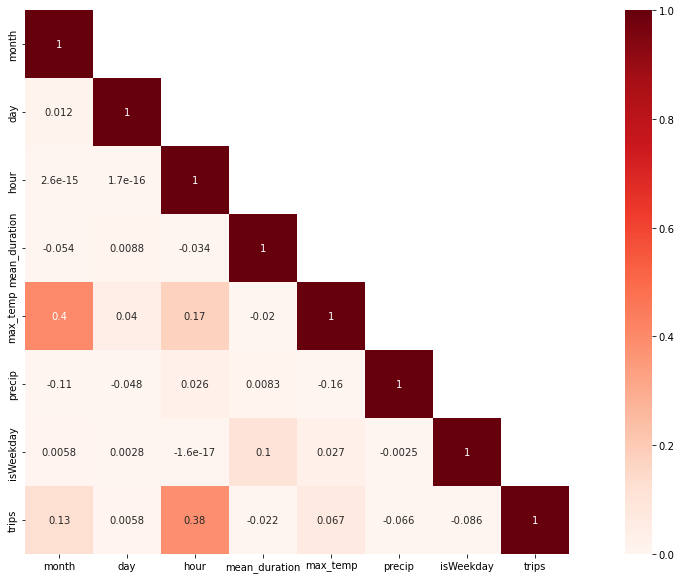

In [111]:
matrix = feature_data[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

• The variables "hour", "month" and "max_temp" seem to be promising features for the bike sharing trip prediction.

# Polynomial Regression
• for one feature -> hour

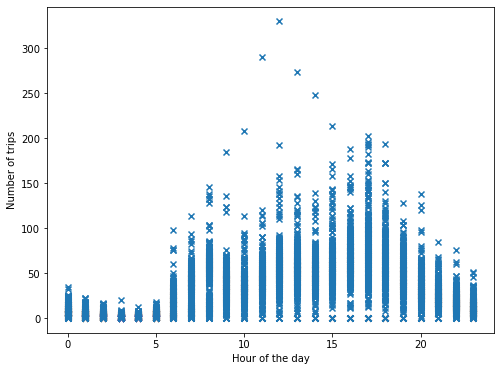

In [88]:
# non-linear relationship
plt.figure(figsize=(8,6))
#sns.scatterplot(data=feature_data, x="hour", y="trips", marker="x")
plt.scatter(feature_data["hour"], feature_data["trips"], marker='x')
plt.xlabel("Hour of the day")
plt.ylabel("Number of trips")
plt.show()

• The relationship between the hours of a day and the number of trips has a non-linear structure => choose polynomial regression

In [7]:
def plot_Poly_regression(X,Y,d):
    
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Trips")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.5063156380175526


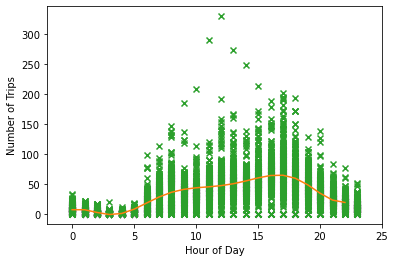

In [8]:
plot_Poly_regression(X =feature_data["hour"].values, Y=feature_data["trips"].values, d = 11)


• highest R^2 is achieved with d=11

### Normalization

In [9]:
def plot_regression_poly_norm(X,Y,d):
    
    
    # Polynomial model:
    poly_reg = PolynomialFeatures (degree = d)
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    
    #Normalizing features:
    lin_reg_2 = LinearRegression(normalize = True)
    lin_reg_2.fit(x_poly, Y)
    model_pred = lin_reg_2.predict(x_poly)
    
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_2.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Trips")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_2.coef_)

The R^2 for quadratic curve is:  0.5072244310382394


/Users/stefaniemarx/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


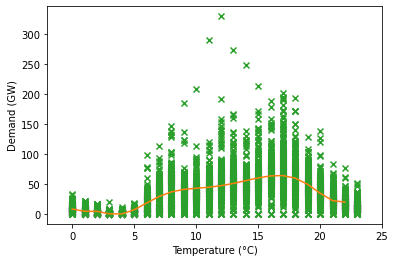

In [11]:
plot_regression_poly_norm(X =feature_data["hour"].values, Y=feature_data["trips"].values, d = 11)

• slightly higher R^2 with normalization : R^2= 0.5072244310382394

### Polynomial regression for more features

In [44]:
# function for polynomial regression
def mult_regression(x,y,d):
    #create features
    PF = PolynomialFeatures(degree = d,interaction_only = False, include_bias = True)
    x_featured = PF.fit_transform(x)
    # create regression
    regression = LinearRegression()
    regression.fit(x_featured,y)

    return regression, PF

In [112]:
# splitting data into test, training and hold out set
# choosing all features
X = feature_data[["month","day","hour",'mean_duration',"max_temp",'precip','isWeekday']]

# split the data with 70% in each set
X_train, X_test, y_train, y_test = train_test_split(X, feature_data["trips"].values, test_size=0.3)

In [119]:
# run regression
regression, PF = mult_regression(X_train,y_train,3) # d=3 best
X_test_poly = PF.transform(X_test)

print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 414.43400569726737
MAE: 13.323592286078695
R^2: 0.5466621623172684


=> higher R^2

In [144]:
# choosing all features except precip, mean_duration
X = feature_data[["month","day","hour","max_temp",'isWeekday']]
X_train, X_test, y_train, y_test = train_test_split(X, feature_data["trips"].values, test_size=0.3)

In [154]:
# run regression
regression, PF = mult_regression(X_train,y_train,7) # d=7 am besten
X_test_poly = PF.transform(X_test)

print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 368.74040365358707
MAE: 11.989862786702862
R^2: 0.587238754410987


=> higher R^2 when excluding precip and mean_duration

In [181]:
# choosing all features except precip, mean_duration, day
X = feature_data[["month","hour","max_temp",'isWeekday']]
X_train, X_test, y_train, y_test = train_test_split(X, feature_data["trips"].values, test_size=0.3)

In [186]:
# run regression
regression, PF = mult_regression(X_train,y_train,7) # d=7 am besten
X_test_poly = PF.transform(X_test)

print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 366.2362120576688
MAE: 11.945771022659459
R^2: 0.5902135340187418


=> higher R^2 when excluding also day

In [209]:
# choosing all features except precip, mean_duration, month, day
X = feature_data[["hour","max_temp",'isWeekday']]
X_train, X_test, y_train, y_test = train_test_split(X, feature_data["trips"].values, test_size=0.3)

In [210]:
# run regression
regression, PF = mult_regression(X_train,y_train,11) # d=11 am besten
X_test_poly = PF.transform(X_test)

print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

MSE: 337.17591938387613
MAE: 10.795525498523089
R^2: 0.6240084598375017


=> highest R^2 with hour, max_temp and isWeekday

In [ ]:
# test regression
X_test_poly = PF.transform(X_test)
print("MSE: "+str(mean_squared_error(y_test,regression.predict(X_test_poly))))
print("MAE: "+str(mean_absolute_error(y_test,regression.predict(X_test_poly))))
print("R^2: "+ str(r2_score(y_test,regression.predict(X_test_poly))))

## Cross validation
70% of the data "new" training set, 30% holdout or validation set. 

In [24]:
# split the data with 70% in each set
X_train, X_test, y_train, y_test = train_test_split(feature_data["hour"].values, feature_data["trips"].values, test_size=0.3)

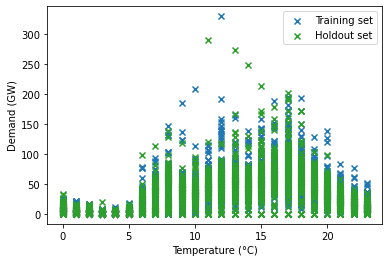

In [25]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])

In [26]:
# fit the model on one set of data

poly_reg = PolynomialFeatures (degree = 6)
x_poly = poly_reg.fit_transform(X_train.reshape(-1,1))

model = LinearRegression(normalize = True)
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(X_test.reshape(-1,1)))
print ('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))

The R^2 for quadratic curve is:  0.4784925799682255


/Users/stefaniemarx/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


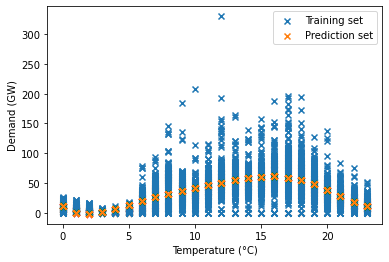

In [27]:
plt.scatter(X_train, y_train, marker='x', color="C0")
plt.scatter(X_test, y_pred, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Prediction set'])

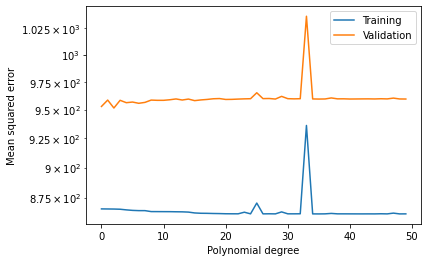

In [28]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
#plt.savefig('crossvalidation error .png', dpi = 500)